In [ ]:
import numpy as np

### Convert npz lsun bedroom dataset to jpgs

In [ ]:
img_array = np.load('VIRTUAL_lsun_bedroom256/arr_0.npy')

In [ ]:
!mkdir lsun_bedroom_data/test lsun_bedroom_data/train

In [ ]:
for i,img in enumerate(img_array):
    if i < 4000:
        plt.imsave(f'lsun_bedroom_data/train/{i}.jpg',img)
    else:
        plt.imsave(f'lsun_bedroom_data/test/{i}.jpg',img)

#### Create train.txt and test.txt as mentioned in the github

In [ ]:
!find ./lsun_bedroom_data/train -name "*.jpg" > train.txt
!find ./lsun_bedroom_data/test -name "*.jpg" > test.txt

#### Run the below cell to train the model

In [ ]:
!python main.py --base configs/custom_vqgan.yaml -t True --gpus 0,1

#### Code for Image reconstruction 

In [1]:
import sys
import yaml
import torch
from omegaconf import OmegaConf
from taming.models.vqgan import VQModel, GumbelVQ
from tqdm import tqdm


sys.path.append(".")
# also disable grad to save memory
torch.set_grad_enabled(False)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/student/2020/cs20btech11028/anaconda3/envs/taming/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_config(config_path, display=False):
    config = OmegaConf.load(config_path)
    if display:
        print(yaml.dump(OmegaConf.to_container(config)))
    return config

def load_vqgan(config, ckpt_path=None, is_gumbel=False):
    if is_gumbel:
        model = GumbelVQ(**config.model.params)
    else:
        model = VQModel(**config.model.params)
    if ckpt_path is not None:
        sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
        missing, unexpected = model.load_state_dict(sd, strict=False)
    return model.eval()

def preprocess_vqgan(x):
    x = 2.*x - 1.
    return x

def custom_to_pil(x):
    x = x.detach().cpu()
    x = torch.clamp(x, -1., 1.)
    x = (x + 1.)/2.
    x = x.permute(1,2,0).numpy()
    x = (255*x).astype(np.uint8)
    x = Image.fromarray(x)
    if not x.mode == "RGB":
        x = x.convert("RGB")
    return x

def reconstruct_with_vqgan(x, model):
    # could also use model(x) for reconstruction but use explicit encoding and decoding here
    z, _, [_, _, indices] = model.encode(x)
    # print(f"VQGAN --- {model.__class__.__name__}: latent shape: {z.shape[2:]}")
    xrec = model.decode(z)
    return xrec

In [ ]:
# def sample_with_vqgan(model, codebook_dim, code_shape, num_samples=1):
#     z = torch.randint(0, codebook_dim, code_shape)
#     z = z.to(DEVICE)
#     xgen = model.decode(z)
#     return xgen

In [3]:
config1024 = load_config("logs/vqgan_imagenet_f16_1024/configs/model.yaml", display=False)
config16384 = load_config("logs/vqgan_imagenet_f16_16384/configs/model.yaml", display=False)

# Corresponding to f16
model1024 = load_vqgan(config1024, ckpt_path="logs/vqgan_imagenet_f16_1024/checkpoints/last.ckpt").to(DEVICE)
model16384 = load_vqgan(config16384, ckpt_path="logs/vqgan_imagenet_f16_16384/checkpoints/last.ckpt").to(DEVICE)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


#### Self-Trained Model
(Works only after the model is trained, else it will throw an error, Make sure to change the file name in the code)

In [4]:
config1 = load_config("logs/2023-10-22T13-47-00_custom_vqgan/configs/2023-10-22T13-47-00-project.yaml", display=False)
model1 = load_vqgan(config1, ckpt_path="logs/2023-10-22T13-47-00_custom_vqgan/checkpoints/last.ckpt", is_gumbel=False).to(DEVICE)


Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [5]:
# Corresponding to f8
config32x32 = load_config("logs/vqgan_gumbel_f8/configs/model.yaml", display=False)
model32x32 = load_vqgan(config32x32, ckpt_path="logs/vqgan_gumbel_f8/checkpoints/last.ckpt", is_gumbel=True).to(DEVICE)

Working with z of shape (1, 256, 32, 32) = 262144 dimensions.


In [25]:
import io
import os, sys
import requests
import PIL
from PIL import Image
from PIL import ImageDraw, ImageFont
import numpy as np

import torch
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from IPython.display import display, display_markdown

font = ImageFont.truetype("./LiberationSans-Regular.ttf", 18)
# font = ImageFont.load_default()

def download_image(url,web=False):
    if web:
        resp = requests.get(url)
        resp.raise_for_status()
        img = PIL.Image.open(io.BytesIO(resp.content))
        return img
    return PIL.Image.open(url)


def preprocess(img, target_image_size=256):
    s = min(img.size)

    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')

    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    
    return img

def stack_reconstructions(input, x0, x1, x2, titles=[]):
    assert input.size == x1.size == x2.size # == x3.size
    w, h = input.size[0], input.size[1]
    img = Image.new("RGB", (4*w, h))
    img.paste(input, (0,0))
    img.paste(x0, (1*w,0))
    img.paste(x1, (2*w,0))
    img.paste(x2, (3*w,0))
#     img.paste(x3, (4*w,0))
    for i, title in enumerate(titles):
        ImageDraw.Draw(img).text((i*w, 0), f'{title}', "black", font=font) # coordinates, text, color, font
    return img

### Reconstruct Images by specifying path

In [7]:
titles=["Input", "VQGAN (f8, 8192)", 
        "VQGAN (f16, 16384)", "VQGAN (f16, 1024)"]

def reconstruction_pipeline(url, web=False,size=320,output=False):
    x_vqgan = preprocess(download_image(url,web), target_image_size=size)
    x_vqgan = x_vqgan.to(DEVICE)

    # print(f"input is of size: {x_vqgan.shape}")
    x0 = reconstruct_with_vqgan(preprocess_vqgan(x_vqgan), model32x32)
    x1 = reconstruct_with_vqgan(preprocess_vqgan(x_vqgan), model16384)
    x2 = reconstruct_with_vqgan(preprocess_vqgan(x_vqgan), model1024)
    img = stack_reconstructions(custom_to_pil(preprocess_vqgan(x_vqgan[0])),  
                              custom_to_pil(x0[0]), custom_to_pil(x1[0]), 
                              custom_to_pil(x2[0]), titles=titles)
    if output:
        return img
    return x0,x1,x2

#### Reconstruction Output of trained Image

input is of size: torch.Size([1, 3, 256, 256])


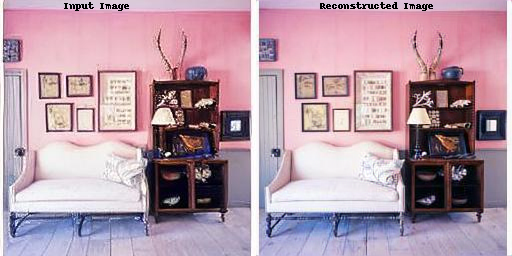

In [8]:
x_vqgan = preprocess(download_image("./lsun_bedroom_data/train_1/1.jpg"), target_image_size=256)
x_vqgan = x_vqgan.to(DEVICE)

print(f"input is of size: {x_vqgan.shape}")
x0 = reconstruct_with_vqgan(preprocess_vqgan(x_vqgan), model1)
input = (download_image("./lsun_bedroom_data/train_1/1.jpg"))
opt = custom_to_pil(x0[0])
w, h = input.size[0], input.size[1]
img = Image.new("RGB", (2*w, h))
img.paste(input, (0,0))
img.paste(opt, (1*w,0))
font = ImageFont.load_default()
for i, title in enumerate(['Input Image', 'Reconstructed Image']):
        ImageDraw.Draw(img).text((i*w + w/4, 0), f'{title}', "black", font=font) # coordinates, text, color, font
img

#### Creating reconstruction samples for calculation of FID scores on LSUN bedroom dataset

In [ ]:
!mkdir lsun_bedroom_data/train_1 lsun_bedroom_data/train_2 lsun_bedroom_data/train_3

In [ ]:
for lnk in os.listdir('lsun_bedroom_data/train'):
    x0,x1,x2 = reconstruction_pipeline(url='lsun_bedroom_data/train/'+lnk, size=256)
    x0 = custom_to_pil(x0[0])
    x1 = custom_to_pil(x1[0])
    x2 = custom_to_pil(x2[0])
    x0.save('lsun_bedroom_data/train_1/'+lnk)
    x1.save('lsun_bedroom_data/train_2/'+lnk)
    x2.save('lsun_bedroom_data/train_3/'+lnk)

#### Calculating FID Scores

In [11]:
!python -m pytorch_fid lsun_bedroom_data/train lsun_bedroom_data/train_1 --device cuda:0

100%|███████████████████████████████████████████| 80/80 [00:08<00:00,  9.41it/s]
FID:  4.502094701824632


In [14]:
!python -m pytorch_fid lsun_bedroom_data/train lsun_bedroom_data/train_2 --device cuda:0

100%|███████████████████████████████████████████| 80/80 [00:08<00:00,  9.37it/s]
FID:  9.113368203972271


In [15]:
!python -m pytorch_fid lsun_bedroom_data/train lsun_bedroom_data/train_3 --device cuda:0

100%|███████████████████████████████████████████| 80/80 [00:08<00:00,  9.43it/s]
FID:  13.332663018304459


#### Reconstruction Outputs

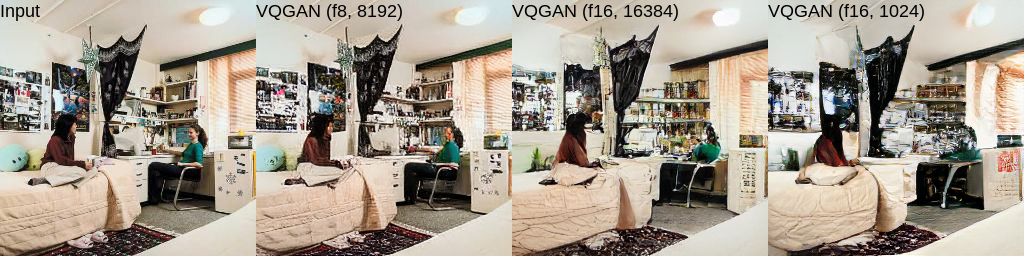

In [27]:
reconstruction_pipeline(url='lsun_bedroom_data/train/100.jpg', size=256,output=True)

In [32]:
img1 = reconstruction_pipeline("https://heibox.uni-heidelberg.de/f/e41f5053cbd34f11a8d5/?dl=1", web=True, output=True,size=384)

In [33]:
img2 = reconstruction_pipeline("https://heibox.uni-heidelberg.de/f/be6f4ff34e1544109563/?dl=1", web=True, output=True,size=384)

In [38]:
img3 = (reconstruction_pipeline("https://heibox.uni-heidelberg.de/f/5cfd15de5d104d6fbce4/?dl=1",web=True, output=True, size=384))

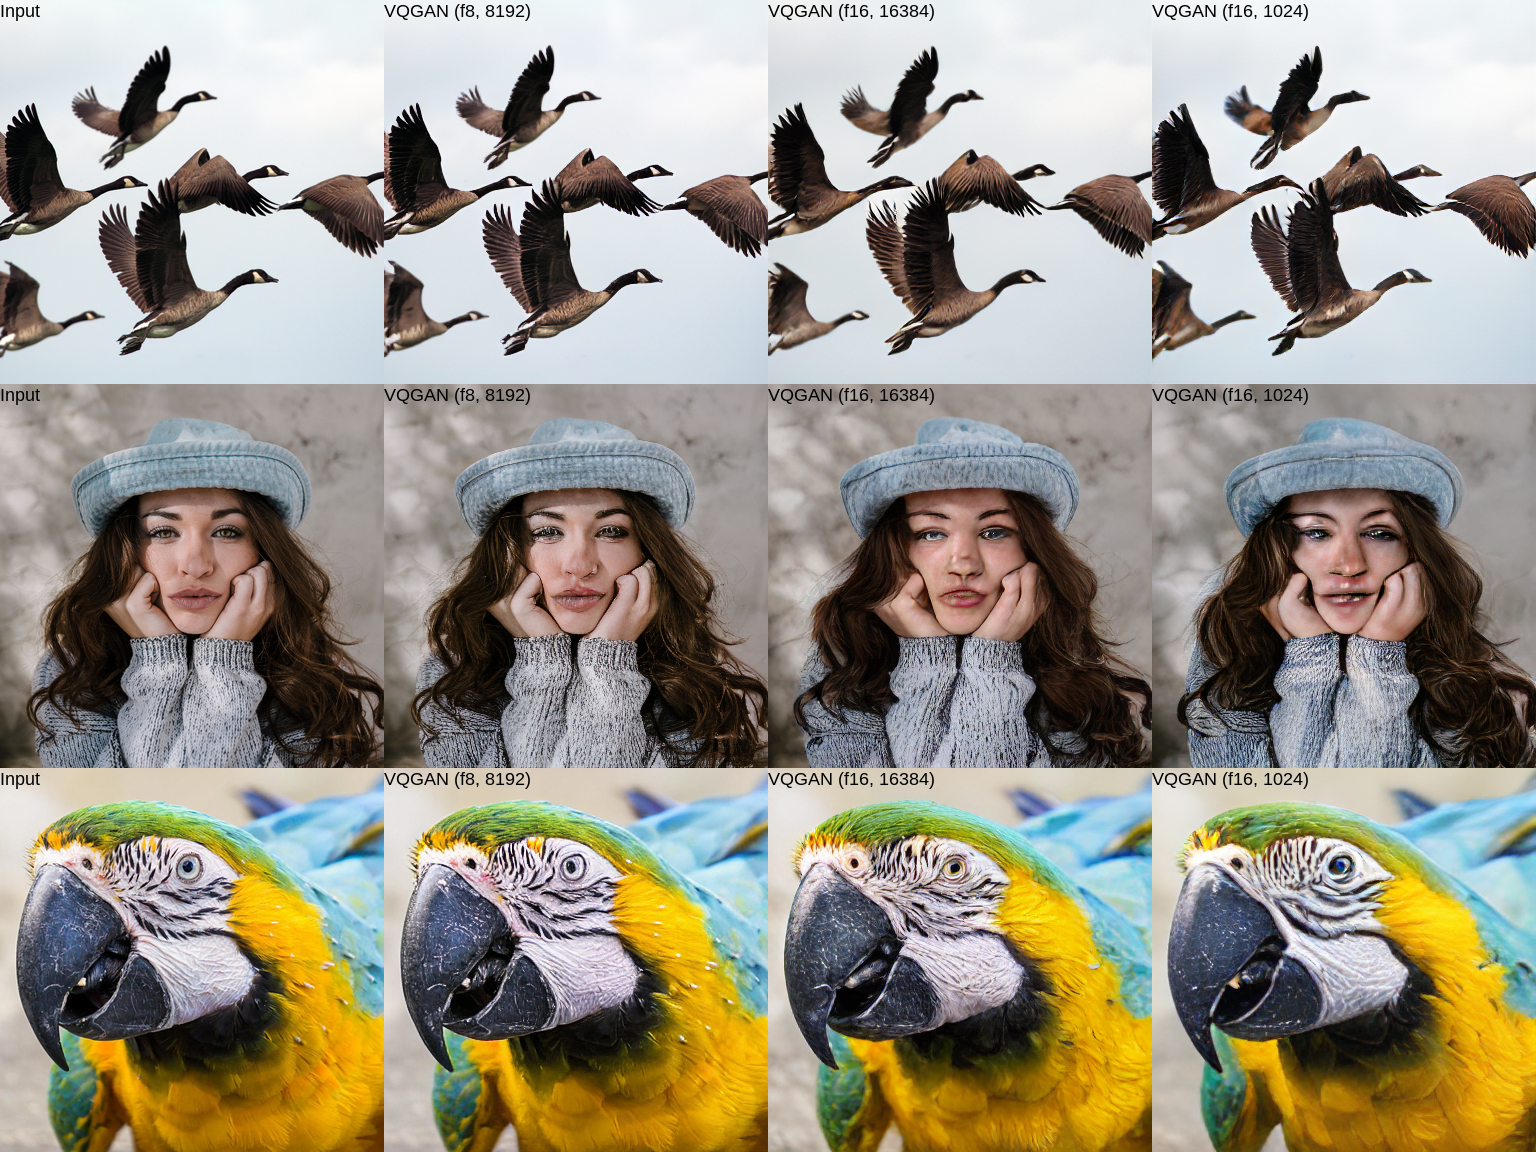

In [40]:
w, h = img1.size
img = Image.new("RGB", (w, 3*h))
img.paste(img1, (0,0))
img.paste(img2, (0,1*h))
img.paste(img3, (0,2*h))
# img.paste(img, (0,3*h))
display(img)

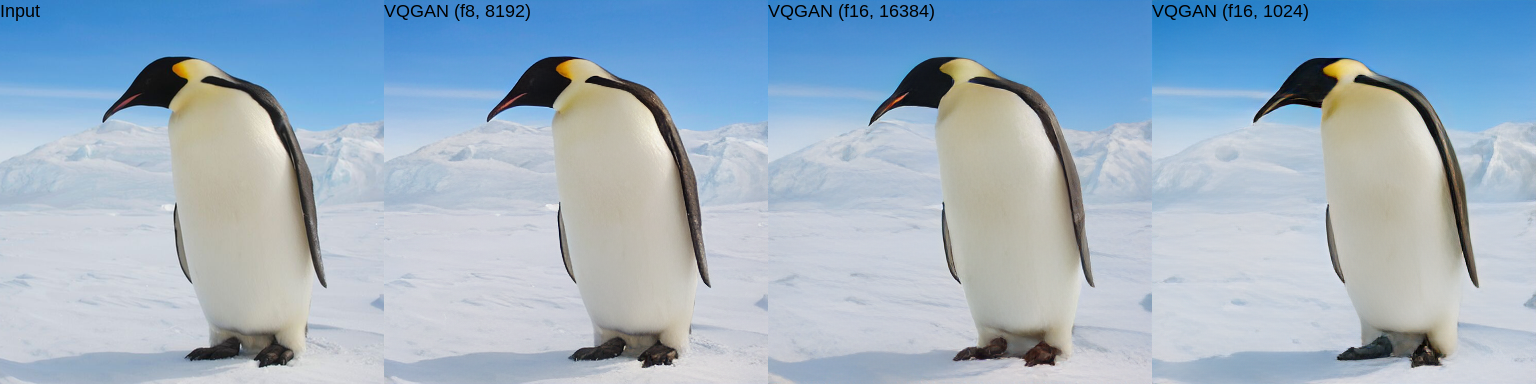

In [41]:
reconstruction_pipeline(url='https://assets.bwbx.io/images/users/iqjWHBFdfxIU/iKIWgaiJUtss/v2/1000x-1.jpg', size=384,output=True,web=True)